In [1]:
# Importing the libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [2]:
# Importing the dataset
file_path = 'C:/Users/sogor/OneDrive/Documents/DataScientist_practice/datasets/Gold.csv'
gold_data = pd.read_csv(file_path, parse_dates=True, index_col='Date')

In [3]:
gold_data.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2022-10-28,1648.3,186519.0,1667.2,1670.9,1640.7
2022-10-27,1668.8,180599.0,1668.8,1674.8,1658.5
2022-10-26,1669.2,183453.0,1657.7,1679.4,1653.8
2022-10-25,1658.0,178706.0,1654.5,1666.8,1641.2
2022-10-24,1654.1,167448.0,1662.9,1675.5,1648.0


In [4]:
# Brief information about my dataset
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2547 entries, 2022-10-28 to 2012-10-31
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  2547 non-null   float64
 1   Volume      2508 non-null   float64
 2   Open        2547 non-null   float64
 3   High        2547 non-null   float64
 4   Low         2547 non-null   float64
dtypes: float64(5)
memory usage: 119.4 KB


Each column except of **Volume** has 2547 entries, indicating there are no missing values, which is beneficial for model building as it eliminates the need for imputation. 

In [5]:
# Addressing the missing values
knn_imputer = KNNImputer()
gold_data['Volume'] = knn_imputer.fit_transform(gold_data[['Volume']])

In [6]:
gold_data.isna().sum()

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [7]:
# Checking for duplicates
print("Number of duplicates:", gold_data.duplicated().sum())

Number of duplicates: 3


In [8]:
# Dropping the duplicates
gold_data = gold_data.drop_duplicates(keep='first')

In [9]:
# Quick summary statistics
gold_data.describe()

,Close/Last,Volume,Open,High,Low
count,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000
mean,1437.656958,182111.392587,1437.844615,1447.192964,1427.982154
std,255.909364,96870.998473,256.249459,257.935203,253.651147
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1243.475000,121540.500000,1243.000000,1251.000000,1235.275000
50%,1318.550000,169662.500000,1319.050000,1326.350000,1310.950000
75%,1698.275000,230469.750000,1701.900000,1715.925000,1684.275000
max,2069.400000,787217.000000,2076.400000,2082.100000,2049.000000


- The `mean` and `median` for the 'Open', 'High', 'Low', 'Close', and 'Adj Close' prices are quite close to each other. This suggests that the distribution of these prices is relatively symmetrical.
- The `standard deviation` for 'Open', 'High', 'Low', 'Close', and 'Adj Close' is around 255, indicating the level of variability in gold prices. This relatively high standard deviation shows that there is considerable fluctuation (it means that the gold prices don't stay the same; they move up and down significantly from day to day.) in gold prices over the dataset.
- The `25% and 75% quartiles` for the price columns suggest the middle 50% of the data is within a narrower range. In other words most price data points are clustered around the center.

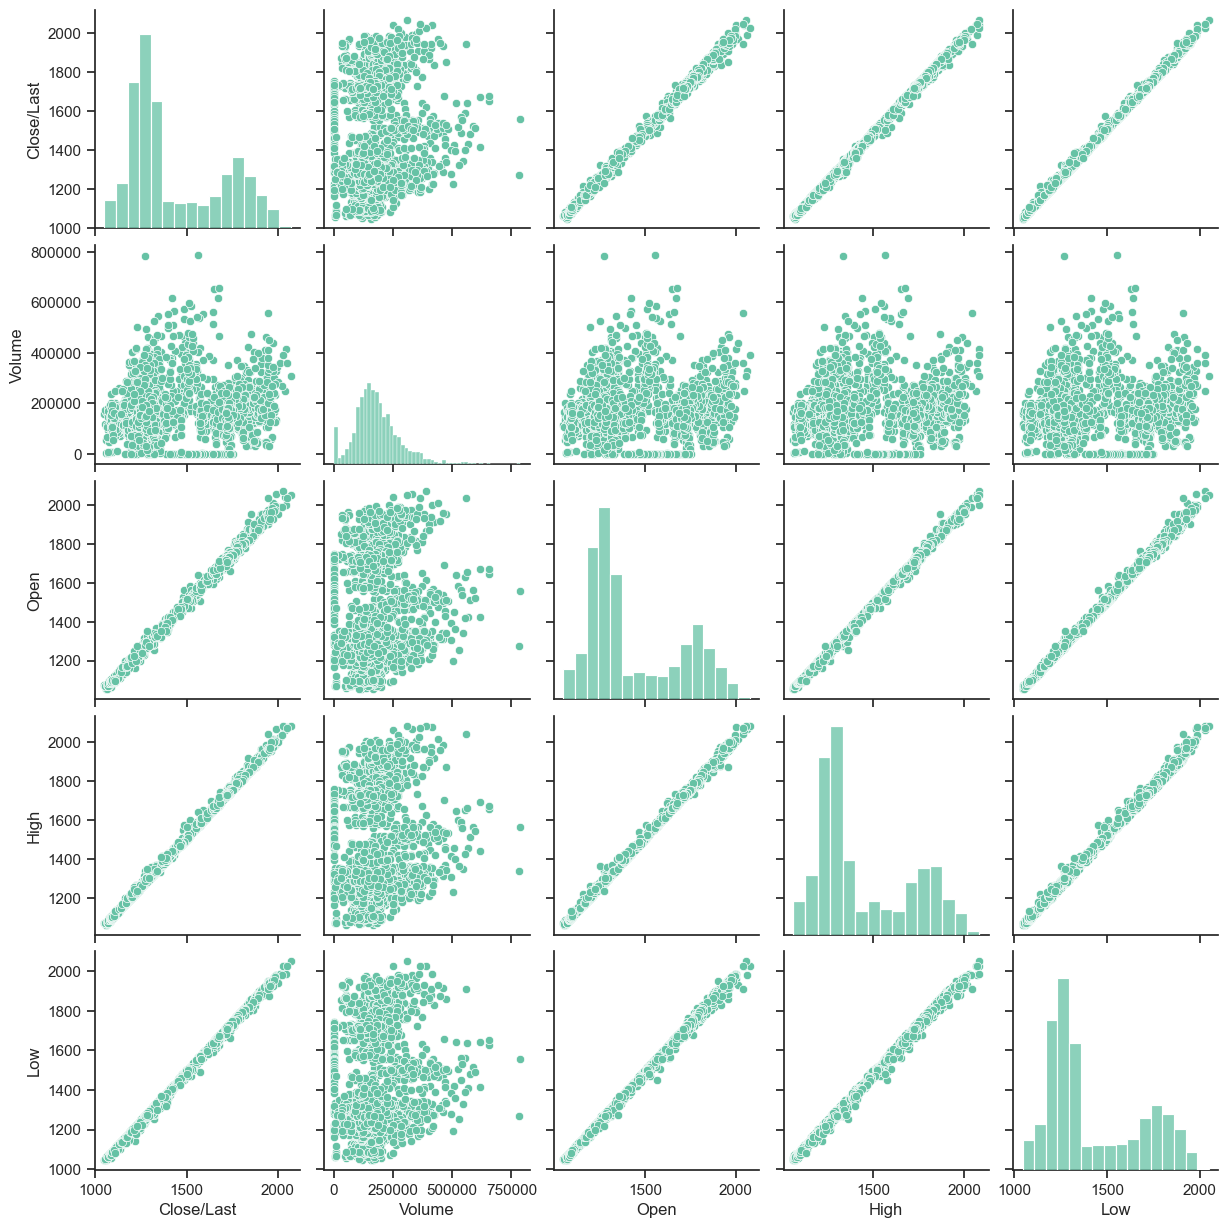

In [10]:
# Pairwise relationships between different variables
sns.set(style="ticks", palette="Set2")
sns.pairplot(gold_data)
plt.show()

The Close/Last, Open, High, and Low prices all show a similar distribution, with a large number of observations clustered around certain price levels, indicating common trading ranges. There are strong linear relationships between these pairs of variables. The scatter plots show a clear linear pattern, indicating that when one of these prices increases or decreases, the others tend to do the same.
The lack of a strong linear pattern in case of Volume and prices indicates that factors other than just price levels influence trading volume, such as market conditions, investor behavior, and external economic factors.

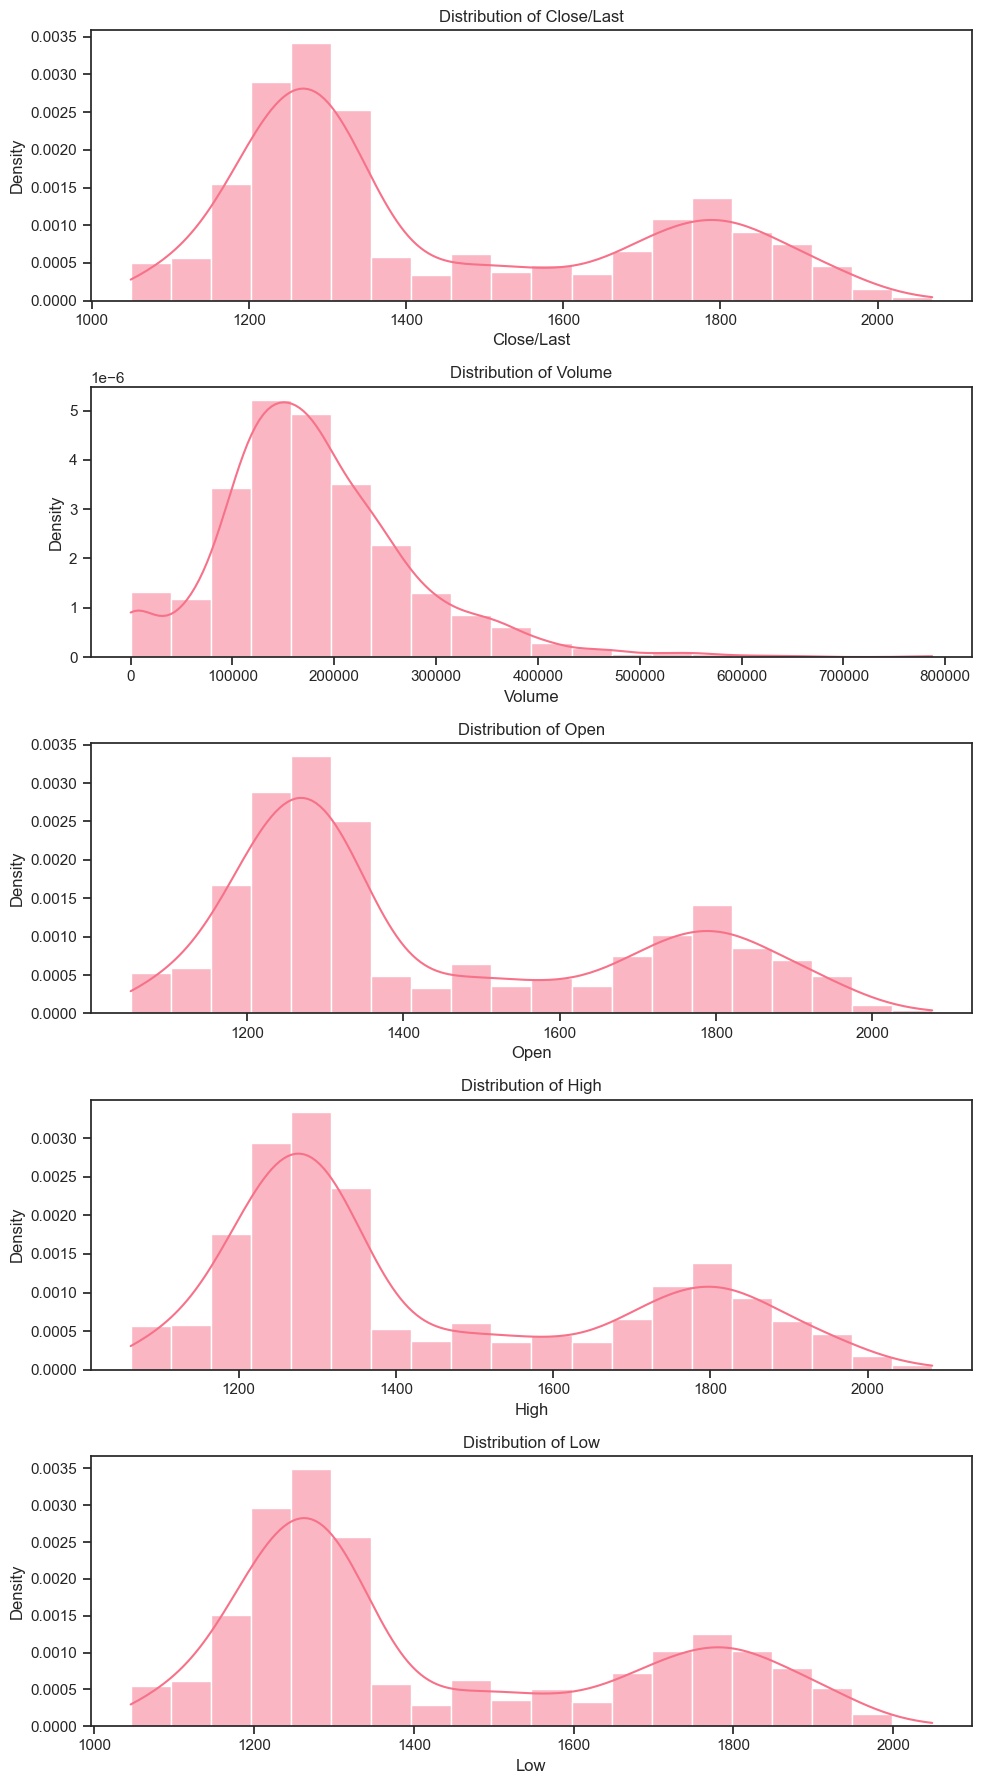

In [11]:
sns.set_palette("husl")

fig, axes = plt.subplots(nrows=len(gold_data.columns), ncols=1, figsize=(10, 18))

for ax, column in zip(axes.flatten(), gold_data.columns):
    sns.histplot(gold_data[column], ax=ax, kde=True, stat='density', bins=20)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

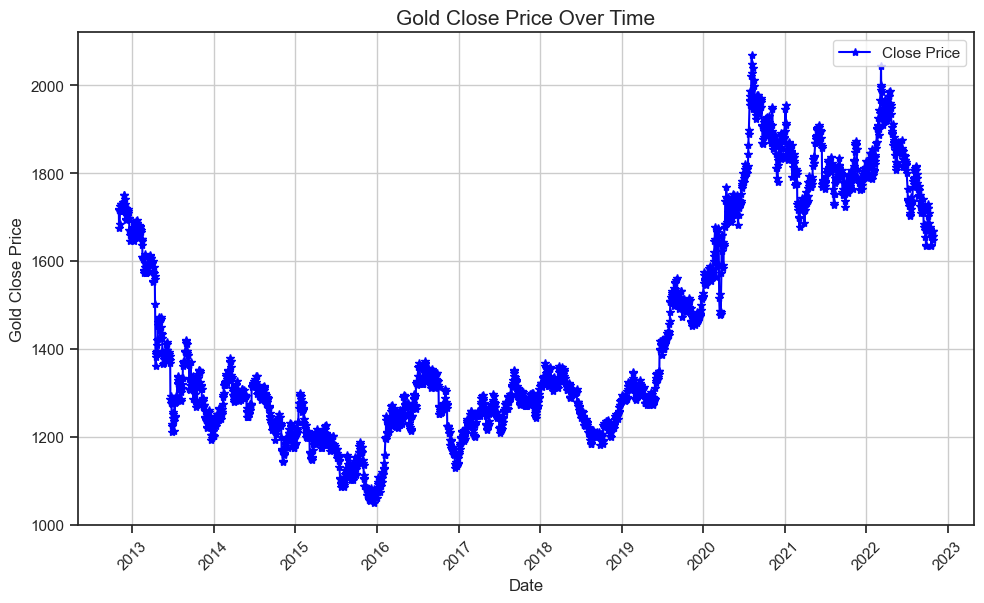

In [12]:
plt.figure(figsize=(10, 6)) 

plt.plot(gold_data.index, gold_data['Close/Last'], marker='*', linestyle='-', color='b', label='Close Price')

plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.title('Gold Close Price Over Time', fontsize=15)
plt.legend()

plt.grid(True) 
plt.tight_layout()  
plt.xticks(rotation=45) 
plt.show()

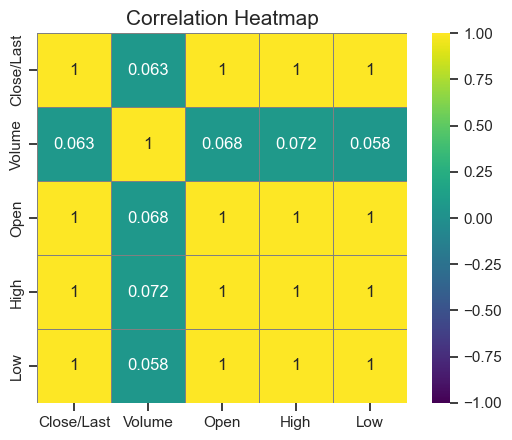

In [13]:
sns.heatmap(gold_data.corr(), annot=True, cmap='viridis', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='gray', cbar=True, square=True)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

All the features have a strong correlation with each other (correlation coefficient of 1.0), except for 'Volume,' which shows a weaker correlation (correlation coefficients ranging from 0.058 to 0.072) with every other variable.

In [14]:
# Declaring my dependent and independent features
X = gold_data.iloc[:, 1:]
y = gold_data.iloc[:, 0]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1780, 4), (764, 4), (1780,), (764,))

In [17]:
# Creating different Pipelines
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', LinearRegression())  
])

pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', SVR())  
])

pipeline_gradient_reg = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', GradientBoostingRegressor())  
])

In [18]:
pipelines = [pipeline_lr, pipeline_svr, pipeline_gradient_reg]

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)

In [19]:
for pipeline in pipelines:
    model_name = pipeline.named_steps['regressor'].__class__.__name__
    print(f"Pipeline for {model_name}:")
    display(pipeline)
    print("\n")

Pipeline for LinearRegression:


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])



Pipeline for SVR:


Pipeline(steps=[('scaler', StandardScaler()), ('regressor', SVR())])



Pipeline for GradientBoostingRegressor:


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', GradientBoostingRegressor())])

In [20]:
for pipeline in pipelines:
    model_name = pipeline.named_steps['regressor'].__class__.__name__  
    y_train_pred = pipeline.predict(X_train)  
    y_test_pred = pipeline.predict(X_test)  

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{model_name} - Train RMSE: {train_rmse:.2f}, Train R^2: {train_r2:.2f}")
    print(f"{model_name} - Test RMSE: {test_rmse:.2f}, Test R^2: {test_r2:.2f}")
    print()

LinearRegression - Train RMSE: 5.90, Train R^2: 1.00
LinearRegression - Test RMSE: 5.53, Test R^2: 1.00

SVR - Train RMSE: 76.49, Train R^2: 0.91
SVR - Test RMSE: 68.78, Test R^2: 0.93

GradientBoostingRegressor - Train RMSE: 5.34, Train R^2: 1.00
GradientBoostingRegressor - Test RMSE: 7.10, Test R^2: 1.00



In [21]:
# Perform cross-validation for all the models
for pipeline in pipelines:
    model_name = pipeline.named_steps['regressor'].__class__.__name__
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  
    print(f"{model_name} - Cross-Validation R^2 Scores: {cv_scores}")
    print(f"{model_name} - Mean R^2 Score: {cv_scores.mean():.2f}")
    print(f"{model_name} - Standard Deviation of R^2 Scores: {cv_scores.std():.2f}")
    print()

LinearRegression - Cross-Validation R^2 Scores: [0.99021497 0.99923472 0.99397772 0.9959916  0.99837625]
LinearRegression - Mean R^2 Score: 1.00
LinearRegression - Standard Deviation of R^2 Scores: 0.00

SVR - Cross-Validation R^2 Scores: [-12.36447021   0.72183283  -0.63302183  -0.87976262   0.99067255]
SVR - Mean R^2 Score: -2.43
SVR - Standard Deviation of R^2 Scores: 5.02

GradientBoostingRegressor - Cross-Validation R^2 Scores: [0.96774261 0.99736773 0.98906147 0.91762976 0.99725052]
GradientBoostingRegressor - Mean R^2 Score: 0.97
GradientBoostingRegressor - Standard Deviation of R^2 Scores: 0.03



**Conclusion**
1. `Linear Regression`: Shows near-perfect R2R2 scores across all folds, with a mean R2R2 score of approximately 1.00.
2. `SVR`: The mean R2R2 score is negative, indicating that on average, SVR performs worse than a simple mean-based prediction.
3. `GradientBoostingRegressor`: The standard deviation is low, indicating stable and reliable performance across different folds.

I would rather choose the *GradientBoostingRegressor* over the other two because it seems to generalize the best, while Linear Regression might overfit, and SVR performs poorly compared to the other two.

In [22]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(pipeline_gradient_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")

Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Best R^2 Score: 0.9990834208167015
Test R^2: 1.00, Test RMSE: 6.54


In [23]:
final_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=300)

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', final_model)
])


final_pipeline.fit(X_train, y_train)

y_test_pred = final_pipeline.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Final Test R^2: {test_r2:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")

Final Test R^2: 0.9993
Final Test RMSE: 6.5902


In [24]:
# Model deployment part
import joblib

joblib.dump(final_pipeline, 'gold_price_model.pkl')

['gold_price_model.pkl']